# Load the model

In [1]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import glob
import time
import numpy as np
import pandas as pd
import mmcv, cv2
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from IPython import display
from tqdm import tqdm
from matplotlib import pyplot as plt

Image.__version__

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [2]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.75)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 32)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
#         out = self.fc2(out)
#         out = self.elu(out)
#         out = self.fc3(out)
#         out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
        return hidden

In [3]:
input_size = 512
output_size = 1
hidden_dim = 64
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
model.load_state_dict(torch.load('model_1face.pt'))

<All keys matched successfully>

In [23]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss
import seaborn as sns

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Positive', 'Nagative'], 
                         columns = ['Positive', 'Nagative'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 1 Face

In [7]:
X = []
Y = []
for p in tqdm(np.arange(0, 50), total = 50):
    X_p = torch.load('data_processed/1face_X_part' + str(p) + '.pt', map_location = device)
    Y_p = torch.load('data_processed/1face_Y_part' + str(p) + '.pt', map_location = device)
    X = X + X_p
    Y = Y + Y_p

100%|██████████| 50/50 [01:30<00:00,  2.00s/it]


In [8]:
print(len(X))

print(len(Y))

X = torch.stack(X)

X.shape

104343
104343


torch.Size([104343, 30, 512])

In [113]:
predict = []
test_loader = DataLoader(TensorDataset(X), shuffle=False, batch_size=1)
test_h = model.init_hidden(1)

for inp in test_loader:
    test_h = tuple([each.data for each in test_h])
    inp = inp[0].to(device)
    out, test_h = model(inp, test_h)
    y = out.squeeze().cpu().data.numpy().item(0)
    predict.append(y)

In [114]:
len(predict)

104343

In [115]:
threshold = Find_Optimal_Cutoff(Y, predict)
print("the optimal threshold is " + str(threshold[0]))
predict_b = [1 if p > threshold[0] else 0 for p in predict]

the optimal threshold is 0.1544969230890274


In [117]:
log_loss(Y, predict)

0.31848684327871846

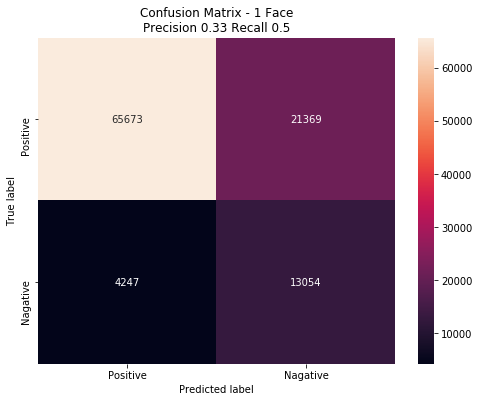

In [118]:
plot_matrix(Y, predict_b, name = '1 Face')

# 2 Faces

In [4]:
X = []
Y = []
for p in tqdm(np.arange(0, 50), total = 50):
    X_p = torch.load('data_processed/2face_X_part' + str(p) + '.pt', map_location = device)
    Y_p = torch.load('data_processed/2face_Y_part' + str(p) + '.pt', map_location = device)
    X = X + X_p
    Y = Y + Y_p

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [5]:
print(len(X))

print(len(Y))

X = torch.stack(X)

X.shape

8648
8648


torch.Size([8648, 60, 512])

In [19]:
predict = []
test_loader = DataLoader(TensorDataset(X), shuffle=False, batch_size=1)
test_h = model.init_hidden(1)

In [20]:
for inp in test_loader:
    test_h = tuple([each.data for each in test_h])
    inp1 = inp[0][0:1, np.arange(1, 60, 2), :].to(device)
    out, test_h = model(inp1, test_h)
    y1 = out.squeeze().cpu().data.numpy().item(0)
    inp2 = inp[0][0:1, np.arange(0, 59, 2), :].to(device)
    out, test_h = model(inp2, test_h)
    y2 = out.squeeze().cpu().data.numpy().item(0)
    y = np.max([y1, y2])
#     print((y1,y2,y))
    predict.append(y)

In [21]:
len(predict)

8648

In [24]:
threshold = Find_Optimal_Cutoff(Y, predict)
print("the optimal threshold is " + str(threshold[0]))
predict_b = [1 if p > threshold[0] else 0 for p in predict]

the optimal threshold is 0.20351463556289673


In [25]:
log_loss(Y, predict)

0.5987685955218536

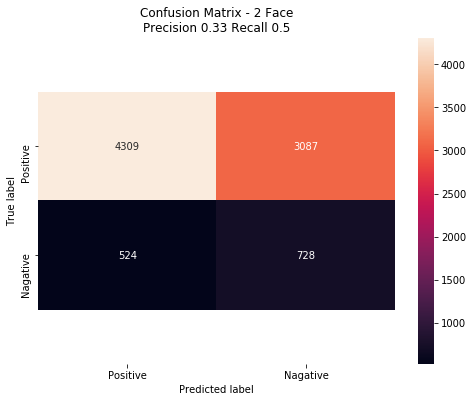

In [27]:
plot_matrix(Y, predict_b, name = '2 Face')

# 3 Faces

In [28]:
X = []
Y = []
for p in tqdm(np.arange(0, 50), total = 50):
    X_p = torch.load('data_processed/3face_X_part' + str(p) + '.pt', map_location = device)
    Y_p = torch.load('data_processed/3face_Y_part' + str(p) + '.pt', map_location = device)
    X = X + X_p
    Y = Y + Y_p

100%|██████████| 50/50 [00:17<00:00,  3.23it/s]


In [29]:
print(len(X))

print(len(Y))

X = torch.stack(X)

X.shape

292
292


torch.Size([292, 90, 512])

In [35]:
predict = []

In [30]:
predict = []
test_loader = DataLoader(TensorDataset(X), shuffle=False, batch_size=1)
test_h = model.init_hidden(1)

In [36]:
for inp in test_loader:
    test_h = tuple([each.data for each in test_h])
    inp1 = inp[0][0:1, np.arange(0, 90, 3), :].to(device)
    out, test_h = model(inp1, test_h)
    y1 = out.squeeze().cpu().data.numpy().item(0)
    inp2 = inp[0][0:1, np.arange(1, 90, 3), :].to(device)
    out, test_h = model(inp2, test_h)
    y2 = out.squeeze().cpu().data.numpy().item(0)
    inp3 = inp[0][0:1, np.arange(2, 90, 3), :].to(device)
    out, test_h = model(inp3, test_h)
    y3 = out.squeeze().cpu().data.numpy().item(0)
    y = np.max([y1, y2, y3])
    print((y1,y2,y))
    predict.append(y)

(0.13426274061203003, 0.003148953663185239, 0.13426274061203003)
(0.08115813881158829, 0.021987425163388252, 0.08115813881158829)
(0.030494483187794685, 0.006471144035458565, 0.030494483187794685)
(0.5278277397155762, 0.0030851804185658693, 0.5278277397155762)
(0.2588379979133606, 0.032625339925289154, 0.2588379979133606)
(0.13528689742088318, 0.012846563942730427, 0.13528689742088318)
(0.043109484016895294, 0.0285347830504179, 0.043109484016895294)
(0.20523834228515625, 0.008270831778645515, 0.20523834228515625)
(0.17594391107559204, 0.004136002156883478, 0.17594391107559204)
(0.01674131117761135, 0.010867494158446789, 0.01674131117761135)
(0.14422182738780975, 0.038259927183389664, 0.14422182738780975)
(0.03410329297184944, 0.11715896427631378, 0.11715896427631378)
(0.17390936613082886, 0.05605607479810715, 0.17390936613082886)
(0.06716287136077881, 0.10981151461601257, 0.4277980327606201)
(0.08688138425350189, 0.17374388873577118, 0.17374388873577118)
(0.29910707473754883, 0.0599429

In [37]:
len(predict)

292

In [38]:
threshold = Find_Optimal_Cutoff(Y, predict)
print("the optimal threshold is " + str(threshold[0]))
predict_b = [1 if p > threshold[0] else 0 for p in predict]

the optimal threshold is 0.18962523341178894


In [39]:
log_loss(Y, predict)

0.6189406834525721

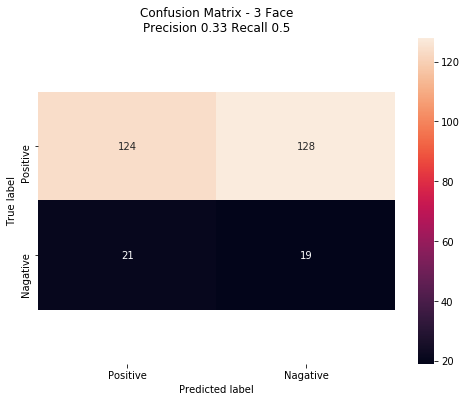

In [41]:
plot_matrix(Y, predict_b, name = '3 Face')